In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import itertools
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import spacy
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
import re
import nltk
import collections
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from empath import Empath
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

Using TensorFlow backend.


In [4]:
df = pd.read_csv('Dataset/data.csv')
df.loc[df['Label']== 0, 'Label'] = 'REAL'
df.loc[df['Label']== 1, 'Label'] = 'FAKE'
df.columns
df['Label'].value_counts()

REAL    2137
FAKE    1872
Name: Label, dtype: int64

In [5]:
#Dropping the column URLs from the table
df.drop(['URLs'], axis = 1, inplace = True)
df.columns

Index(['Headline', 'Body', 'Label'], dtype='object')

In [6]:
#Selecting only fake news from all the types of news and then replacing the 'fake' by 0
df1 = pd.read_csv('Dataset/fake.csv')
df1.columns
df1['type'].value_counts()
df1 = df1.loc[df1['type']=='fake']
df1.loc[df1['type']== 'fake', 'type'] = 'FAKE'

In [7]:
#Selecting some columns from the table and renaming them\n",
df1 = df1[['title','text','type']]
df1.columns = ['Headline', 'Body', 'Label']
df1['Label'].value_counts()

FAKE    19
Name: Label, dtype: int64

In [8]:
df2 = pd.read_csv('Dataset/fake_or_real_news.csv')
df2.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [9]:
#Selecting few columns from the table and renaming the columns
df2 = df2[['title','text','label']]
df2.columns = ['Headline', 'Body', 'Label']
df2.columns
df2['Label'].value_counts()

REAL    3171
FAKE    3164
Name: Label, dtype: int64

In [10]:
df3 = pd.read_csv('Dataset/train.csv')
df3.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

In [11]:
#Selecting few columns from the table and renaming the columns
df3 = df3[['title','text','label']]
df3.columns = ['Headline', 'Body', 'Label']
df3.loc[df3['Label']== 0, 'Label'] = 'REAL'
df3.loc[df3['Label']== 1, 'Label'] = 'FAKE'
df3.columns
df3['Label'].value_counts()

FAKE    10413
REAL    10387
Name: Label, dtype: int64

In [12]:
#Appending df1,df2,df3 to df
df = df.append(df1, ignore_index = True)
df = df.append(df2, ignore_index = True)
df = df.append(df3, ignore_index = True)

In [13]:
df = df.drop_duplicates()

# df.iloc[3647]
# print(df['Headline'][3647])
# print(len(df['Body'][3647]))
#df = df.dropna(how='any',axis=0)
cnt = 0
ind = []
for art in df['Body']:
    #print(type(art))
    if len(str(art)) < 10:
        ind.append(cnt)
    cnt+=1
df = df.drop(df.index[ind])
        

df
# print(df['Headline'][3647])
# print(len(df['Body'][3647]))


,Headline,Body,Label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,FAKE
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",FAKE
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,FAKE
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,FAKE
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",FAKE
5,JetNation FanDuel League; Week 4,JetNation FanDuel League; Week 4\n% of readers...,REAL
6,Kansas Tried a Tax Plan Similar to Trump’s. It...,"In 2012, Kansas lawmakers, led by Gov. Sam Bro...",FAKE
7,"India RBI chief: growth important, but not at ...",The Reserve Bank of India (RBI) Governor Urjit...,FAKE
8,EPA chief to sign rule on Clean Power Plan exi...,"Scott Pruitt, Administrator of the U.S. Enviro...",FAKE
9,Talks on sale of Air Berlin planes to easyJet ...,FILE PHOTO - An Air Berlin sign is seen at an ...,FAKE


In [14]:
df['Label'].value_counts()

REAL    15343
FAKE    12522
Name: Label, dtype: int64

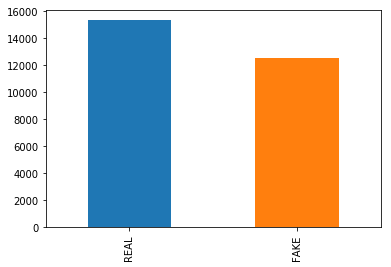

In [15]:
df['Label'].value_counts().plot(kind = 'bar')

In [16]:
df['headline_length'] = [len(str(a)) for a in df['Headline']]
df['headline_length'].describe()

count    27865.000000
mean        69.775381
std         24.885773
min          1.000000
25%         55.000000
50%         70.000000
75%         85.000000
max        653.000000
Name: headline_length, dtype: float64

In [17]:
df['body_length'] = [len(a) for a in df['Body']]
df['body_length'].describe()

count     27865.000000
mean       4429.890903
std        4854.862554
min          10.000000
25%        1589.000000
50%        3348.000000
75%        6106.000000
max      142961.000000
Name: body_length, dtype: float64

In [18]:
df.describe()

,headline_length,body_length
count,27865.000000,27865.000000
mean,69.775381,4429.890903
std,24.885773,4854.862554
min,1.000000,10.000000
25%,55.000000,1589.000000
50%,70.000000,3348.000000
75%,85.000000,6106.000000
max,653.000000,142961.000000


In [19]:
df["Text"] = df["Headline"].map(str) + df["Body"]
y = df.Label
y = y.astype('str')
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'],y, test_size=0.33)
X_train

4258     Donald Trump's GOP civil warPanama City, Flori...
24466    What You Should Watch: Amazon Pilots and ‘Miss...
28155    Part 4 Of O’Keefe’s Project Veritas Videos Has...
28266    Misophonia Sufferers: Scientists May Have Foun...
25623    IS Urges Jihadis To ’Dress Up Like Jews’, Carr...
14063    Freedom Rider: Russophobia: War Party Propagan...
20265    Bob Dylan, the Newest Nobel Laureate, Maintain...
30423    Airbag Propellant Bound for Takata Factory Det...
25876    If Clinton Goes Down, Loretta Lynch Will Go Do...
22322    Report: NBC Cutting Back ’Today’ to Make Room ...
5265     Re: The U.S. Will Lose Global Reserve Status, ...
4785     What Brian Williams’s Chopper Whopper Says Abo...
14883    Woody Harrelson Quits Smoking Pot after 30 Yea...
25502    Be More Productive. Shorten the Workweek. - Th...
14800    Anthony Weiner and Huma Abedin to Separate Aft...
19216    Irwin Stambler, 92, Dies Reference Book Writer...
690      State Department denies Tillerson called Trump.

In [20]:
#Tf-idf Bigrams
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2)) 

# Fit and transform the training data 
tfidf1_train = tfidf_vectorizer.fit_transform(X_train.astype('str')) 

# Transform the test set 
tfidf1_test = tfidf_vectorizer.transform(X_test.astype('str'))

pickle.dump(tfidf1_train, open("tfidf1_train.pickle", "wb"))

pickle.dump(tfidf1_test, open("tfidf1_test.pickle", "wb"))

In [21]:
#Top 10 tfidf bigrams 
tfidf_vectorizer.get_feature_names()[-10:]

['中文 cooperación',
 '中文 coopération',
 '中文 التعاون',
 '大量转体 mediamass',
 '山崎 コロッケ',
 '殆ww reverbnation',
 '点击查看本文中文版 despite',
 '点击查看本文中文版 foreigner',
 '無為 translates',
 '版权所有 2012']

In [22]:
tfidf1_train

<18669x4013463 sparse matrix of type '<class 'numpy.float64'>'
	with 6804483 stored elements in Compressed Sparse Row format>

In [41]:
#Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [96]:
clf = MultinomialNB()
clf.fit(tfidf1_train, Y_train)
pickle.dump(clf, open('tfidf_nb', 'wb'))
pred = clf.predict(tfidf1_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.829


Confusion matrix


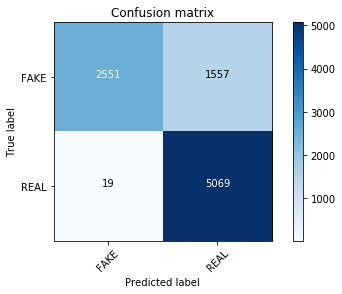

In [97]:
cm = metrics.confusion_matrix(Y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [100]:
clf = GradientBoostingClassifier()
clf.fit(tfidf1_train, Y_train)
pickle.dump(clf, open('tfidf_gb', 'wb'))
#model = pickle.load(open('tfidf_gb', 'rb'))
pred = clf.predict(tfidf1_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

Accuracy with Gradient Boosting:   0.847


Confusion matrix


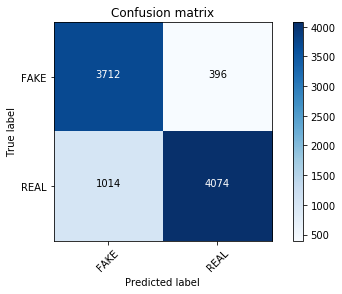

In [101]:
cm = metrics.confusion_matrix(Y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [102]:
clf = RandomForestClassifier()
clf.fit(tfidf1_train, Y_train)
pickle.dump(clf, open('tfidf_rf', 'wb'))
pred = clf.predict(tfidf1_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

Accuracy with RandomForestClassifier:   0.865


Confusion matrix


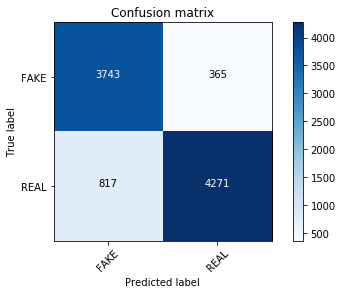

In [34]:
cm = metrics.confusion_matrix(Y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
#Generating the POS tags for all the articles and adding a new column by replacing text with their POS tags
nlp = spacy.load('en_core_web_sm')
x = []
df["Text"] = df["Headline"].map(str) + df["Body"]
for text in df['Text']:
    text_new = []
    doc = nlp(text)
    for token in doc:
        text_new.append(token.pos_)
    txt = ' '.join(text_new)
    x.append(txt)
df['Text_pos'] = x
df.to_pickle('newdata.pkl')

In [40]:
df = pd.read_pickle('newdata.pkl')
cnt = 0
ind = []
for art in df['Body']:
    #print(type(art))
    if len(str(art)) < 10:
        ind.append(cnt)
    cnt+=1
df = df.drop(df.index[ind])

In [41]:
y = df.Label
y = y.astype('str')
x_train, x_test, y_train, y_test = train_test_split(df['Text_pos'],y, test_size=0.33)
x_train

4574     PROPN PROPN PROPN VERB NOUN ADP PROPN PROPN AD...
9417     ADV PROPN VERB PROPN ADP PROPN VERB VERB PART ...
21627    NOUN PUNCT ADJ NOUN VERB NUM ADP VERB ADJ ADP ...
4755     PUNCT PUNCT PUNCT PROPN PUNCT PUNCT PUNCT NOUN...
19184    PROPN PROPN PROPN PROPN PROPN PROPN VERB VERB ...
19182    ADP PRON VERB ADJ ADP DET PROPN ADP DET PROPN ...
28908    NOUN VERB ADP PROPN PROPN NOUN PUNCT PUNCT PRO...
1589     PROPN PART PROPN PUNCT PROPN SYM PROPN PROPN P...
14069    NUM PROPN PROPN CCONJ PROPN PROPN VERB ADP PRO...
20099    PROPN NUM PUNCT PROPN PROPN PROPN NUM PUNCT AD...
1578     VERB PRON VERB ADP DET PROPN PROPN PRON VERB A...
21617    PROPN PROPN PROPN PROPN ADP PROPN PROPN PROPN ...
24919    NUM NOUN ADP PROPN PART PROPN PROPN PUNCT DET ...
17073    PROPN VERB VERB PROPN PROPN PROPN ADV ADP NOUN...
9210     PROPN VERB PRON ADV PUNCT ADV ADP PROPN ADJ AD...
26110    PROPN PROPN PROPN PROPN PROPN PUNCT NOUN VERB ...
19032    PROPN PUNCT ADJ VERB ADV ADP PROPN PROPN PUNCT.

In [42]:
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2)) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(x_train.astype('str')) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(x_test.astype('str'))

pickle.dump(tfidf_train, open("tfidf_train.pickle", "wb"))

pickle.dump(tfidf_test, open("tfidf_test.pickle", "wb"))

In [28]:
tfidf_vectorizer.get_feature_names()[-10:]

['verb det',
 'verb intj',
 'verb noun',
 'verb num',
 'verb pron',
 'verb propn',
 'verb punct',
 'verb space',
 'verb sym',
 'verb verb']

In [29]:
tfidf_train

<18772x196 sparse matrix of type '<class 'numpy.float64'>'
	with 1612837 stored elements in Compressed Sparse Row format>

In [30]:
clf = MultinomialNB()
clf.fit(tfidf_train, y_train)
pickle.dump(clf, open('pos_nb', 'wb'))
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.665


Confusion matrix


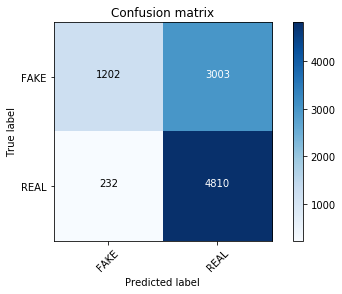

In [43]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [44]:
clf = RandomForestClassifier()
clf.fit(tfidf_train, y_train)
pickle.dump(clf, open('pos_rf', 'wb'))
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

Accuracy with RandomForestClassifier:   0.866


Confusion matrix


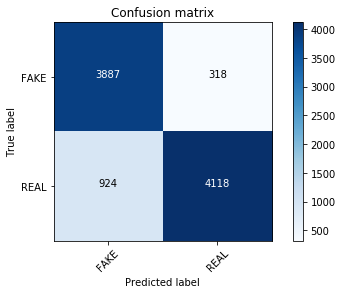

In [45]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [46]:
clf = GradientBoostingClassifier()
clf.fit(tfidf_train, y_train)
pickle.dump(clf, open('pos_gb', 'wb'))
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

Accuracy with Gradient Boosting:   0.883


Confusion matrix


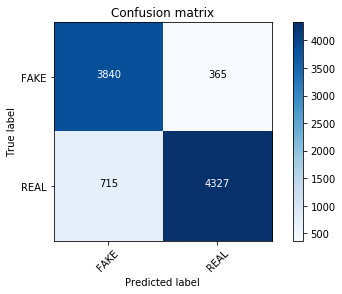

In [47]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [31]:
#Getting the score of semantic categories generated by Empath of each article and generating a tfidf vector of the unigrams 
lexicon = Empath()
semantic = []
cnt = 0
df["Text"] = df["Headline"].map(str) + df["Body"]

for article in df['Text']:
    if article == '':
        continue
    cnt+=1
    d = lexicon.analyze(article, normalize = False)
    x = []
    for key, value in d.items():
        x.append(value)
    x = np.asarray(x)
    semantic.append(x)
df['Semantic'] = semantic

In [32]:
categories = []
a = lexicon.analyze("")
for key, value in a.items():
    categories.append(key)
categories

['exercise',
 'horror',
 'hearing',
 'college',
 'science',
 'car',
 'government',
 'toy',
 'rural',
 'poor',
 'strength',
 'music',
 'weather',
 'payment',
 'disappointment',
 'dispute',
 'leader',
 'trust',
 'shame',
 'help',
 'musical',
 'appearance',
 'breaking',
 'ocean',
 'clothing',
 'farming',
 'traveling',
 'fabric',
 'social_media',
 'nervousness',
 'pride',
 'joy',
 'achievement',
 'zest',
 'writing',
 'ridicule',
 'anticipation',
 'suffering',
 'leisure',
 'driving',
 'party',
 'occupation',
 'sympathy',
 'reading',
 'power',
 'banking',
 'communication',
 'healing',
 'ancient',
 'masculine',
 'emotional',
 'affection',
 'messaging',
 'cooking',
 'terrorism',
 'swimming',
 'confusion',
 'death',
 'negative_emotion',
 'sound',
 'valuable',
 'beach',
 'law',
 'beauty',
 'anger',
 'superhero',
 'sailing',
 'restaurant',
 'family',
 'cold',
 'rage',
 'economics',
 'cleaning',
 'play',
 'exasperation',
 'exotic',
 'weapon',
 'positive_emotion',
 'ugliness',
 'royalty',
 'speakin

In [33]:
#TF-IDF vector by taking the score for a semantic class as its frequency.
sem = []
for i in range(df.shape[0]):
    a = []
    for j in range(len(semantic[0])):
        for k in range(int(semantic[i][j])):
            a.append(categories[j])
    b = " ".join(a)
    sem.append(b)
#print(len(sem))
df['Semantics'] = sem
df.to_pickle('Semantic.pkl')

In [34]:
df = pd.read_pickle('Semantic.pkl')
print(df.columns)
print(df.shape)

Index(['Headline', 'Body', 'Label', 'headline_length', 'body_length',
       'Body_pos', 'Text_pos', 'Text', 'Semantic', 'Semantics'],
      dtype='object')
(27865, 10)


In [45]:
y = df.Label
y = y.astype('str')
x_train, x_test, y_train, y_test = train_test_split(df['Semantics'],y, test_size=0.33)
x_train

11942    [3.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...
16974    [0.0, 0.0, 0.0, 2.0, 5.0, 0.0, 2.0, 1.0, 0.0, ...
27421    [10.0, 6.0, 0.0, 7.0, 5.0, 2.0, 0.0, 10.0, 0.0...
2099     [0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...
456      [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...
20244    [4.0, 10.0, 0.0, 1.0, 2.0, 3.0, 1.0, 37.0, 0.0...
18196    [2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4110     [6.0, 4.0, 1.0, 33.0, 3.0, 1.0, 0.0, 10.0, 0.0...
7468     [3.0, 0.0, 0.0, 0.0, 4.0, 3.0, 1.0, 0.0, 2.0, ...
16502    [0.0, 0.0, 0.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...
18146    [3.0, 4.0, 0.0, 9.0, 1.0, 2.0, 1.0, 5.0, 2.0, ...
6491     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
111      [1.0, 1.0, 1.0, 1.0, 0.0, 3.0, 0.0, 0.0, 0.0, ...
9181     [7.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, ...
30433    [8.0, 8.0, 4.0, 3.0, 2.0, 0.0, 0.0, 2.0, 0.0, ...
14557    [6.0, 0.0, 0.0, 2.0, 5.0, 1.0, 2.0, 0.0, 2.0, ...
4720     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, .

In [ ]:
print(type(x_train))
print(x_train.shape)

In [ ]:
#Initialize the `tfidf_vectorizer` 
tfidf2_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1)) 

# Fit and transform the training data 
tfidf2_train = tfidf2_vectorizer.fit_transform(x_train.astype('str')) 

# Transform the test set 
tfidf2_test = tfidf2_vectorizer.transform(x_test.astype('str'))

pickle.dump(tfidf2_train, open("tfidf2_train.pickle", "wb"))

pickle.dump(tfidf2_test, open("tfidf2_test.pickle", "wb"))

In [ ]:
clf = MultinomialNB()
#type(x_train.tolist())
clf.fit(x_train.tolist(), y_train)
pickle.dump(clf, open('sem_nb', 'wb'))
pred = clf.predict(x_test.tolist())
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

In [ ]:
clf = RandomForestClassifier()
clf.fit(x_train.tolist(), y_train)
pickle.dump(clf, open('sem_rf', 'wb'))
pred = clf.predict(x_test.tolist())
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

In [ ]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(x_train.tolist(), y_train)
pickle.dump(clf, open('sem_gb', 'wb'))
pred = clf.predict(x_test.tolist())
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

Confusion matrix


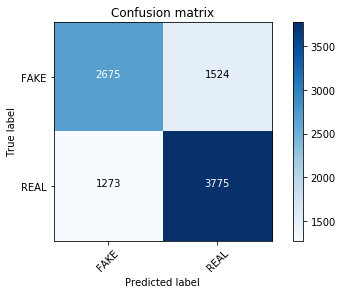

In [58]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
#Combining the 3 feature vectors
import scipy.sparse as sp
# ui = sp.vstack(tfidf_train, tfidf1_train)
# yu = tfidf_train.data.tolist()
# yu.append(tfidf1_train.tolist())
# test = tfidf_test.data.tolist() + x_test.tolist()
#print(type(tfidf_train), tfidf_train.shape)
#print(type(tfidf1_train), tfidf1_train.shape)
# print(type(x_train), x_train.shape)
diff_n_rows = tfidf_train.shape[0] - tfidf1_train.shape[0]

Xb_new = sp.vstack((tfidf1_train, sp.csr_matrix((diff_n_rows, tfidf1_train.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

c = sp.hstack((tfidf_train, Xb_new))

diff_n_rows = c.shape[0] - tfidf2_train.shape[0]

Xb_new = sp.vstack((tfidf2_train, sp.csr_matrix((diff_n_rows, tfidf2_train.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

X = sp.hstack((c, Xb_new))
X

dif_n_rows = tfidf_test.shape[0] - tfidf1_test.shape[0]

Xb_ne = sp.vstack((tfidf1_test, sp.csr_matrix((dif_n_rows, tfidf1_test.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

d = sp.hstack((tfidf_test, Xb_ne))

dif_n_rows = d.shape[0] - tfidf2_test.shape[0]

Xb_ne = sp.vstack((tfidf2_test, sp.csr_matrix((dif_n_rows, tfidf2_test.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

Y = sp.hstack((d, Xb_ne))



In [ ]:
clf = MultinomialNB()
#print(type(train), type(y_train.tolist()))
clf.fit(X, y_train)
pickle.dump(clf, open('pos_sem_nb', 'wb'))
pred = clf.predict(Y)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

In [ ]:
clf = RandomForestClassifier()
clf.fit(X, y_train)
pickle.dump(clf, open('pos_sem_rf', 'wb'))
pred = clf.predict(Y)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

In [ ]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [174]:
clf = GradientBoostingClassifier()
clf.fit(X, y_train)
pickle.dump(clf, open('pos_sem_gb', 'wb'))
pred = clf.predict(Y)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

Accuracy with Gradient Boosting:   0.882


Confusion matrix


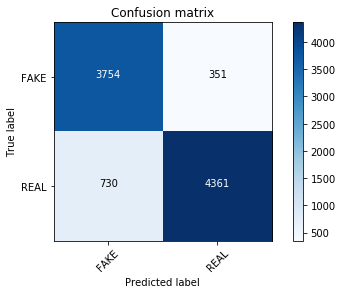

In [175]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [164]:
#Directly loading the final dateframe by loading the pickle file from the previously saved pickle file
df = pd.read_pickle('Semantic.pkl')
print(df.columns)
print(df.shape)

Index(['Headline', 'Body', 'Label', 'headline_length', 'body_length',
       'Body_pos', 'Text_pos', 'Text', 'Semantic', 'Semantics'],
      dtype='object')
(27865, 10)


In [165]:
y = df.Label
x_train, x_test, y_train, y_test = train_test_split(df,y, test_size=0.33)

In [166]:
x_train_text = x_train['Text']
x_test_text = x_test['Text']
x_train_text_pos = x_train['Text_pos']
x_test_text_pos = x_test['Text_pos']
x_train_semantics = x_train['Semantics']
x_test_semantics = x_test['Semantics']

In [167]:
#Tf-idf Bigrams
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2), max_features = 20000) 

# Fit and transform the training data 
tfidf1_train = tfidf_vectorizer.fit_transform(x_train_text.astype('str')) 

# Transform the test set 
tfidf1_test = tfidf_vectorizer.transform(x_test_text.astype('str'))

pickle.dump(tfidf1_train, open("tfidf1_train.pickle", "wb"))

pickle.dump(tfidf1_test, open("tfidf1_test.pickle", "wb"))

In [168]:
#POS
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2)) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(x_train_text_pos.astype('str')) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(x_test_text_pos.astype('str'))

pickle.dump(tfidf_train, open("tfidf_train.pickle", "wb"))

pickle.dump(tfidf_test, open("tfidf_test.pickle", "wb"))

In [169]:

#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1)) 

# Fit and transform the training data 
tfidf2_train = tfidf_vectorizer.fit_transform(x_train_semantics.astype('str')) 

# Transform the test set 
tfidf2_test = tfidf_vectorizer.transform(x_test_semantics.astype('str'))

pickle.dump(tfidf2_train, open("tfidf_train.pickle", "wb"))

pickle.dump(tfidf2_test, open("tfidf_test.pickle", "wb"))

In [170]:
ttf1_train = tfidf1_train
ttf1_test = tfidf1_test
ttf_train = tfidf_train
ttf_test = tfidf_test
ttf2_train = tfidf2_train
ttf2_test = tfidf2_test

In [218]:
#Giving weights to each of the 3 feature vectors generated
big_w = 0.35
synt_w = 0.5
sem_w = 0.15
big_w *= 3
synt_w *= 3
sem_w *= 3
tfidf1_train = big_w*ttf1_train
tfidf1_test = big_w*ttf1_test
tfidf_train = synt_w*ttf_train
tfidf_test = synt_w*ttf_test
tfidf2_train = sem_w*ttf2_train
tfidf2_test = sem_w*ttf2_test

In [219]:
import scipy.sparse as sp
# ui = sp.vstack(tfidf_train, tfidf1_train)
# yu = tfidf_train.data.tolist()
# yu.append(tfidf1_train.tolist())
# test = tfidf_test.data.tolist() + x_test.tolist()
#print(type(tfidf_train), tfidf_train.shape)
#print(type(tfidf1_train), tfidf1_train.shape)
# print(type(x_train), x_train.shape)
diff_n_rows = tfidf_train.shape[0] - tfidf1_train.shape[0]

Xb_new = sp.vstack((tfidf1_train, sp.csr_matrix((diff_n_rows, tfidf1_train.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

c = sp.hstack((tfidf_train, Xb_new))

diff_n_rows = c.shape[0] - tfidf2_train.shape[0]

Xb_new = sp.vstack((tfidf2_train, sp.csr_matrix((diff_n_rows, tfidf2_train.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

X = sp.hstack((c, Xb_new))
X

dif_n_rows = tfidf_test.shape[0] - tfidf1_test.shape[0]

Xb_ne = sp.vstack((tfidf1_test, sp.csr_matrix((dif_n_rows, tfidf1_test.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

d = sp.hstack((tfidf_test, Xb_ne))

dif_n_rows = d.shape[0] - tfidf2_test.shape[0]

Xb_ne = sp.vstack((tfidf2_test, sp.csr_matrix((dif_n_rows, tfidf2_test.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

Y = sp.hstack((d, Xb_ne))


In [220]:
clf = MultinomialNB()
#type(x_train.tolist())
clf.fit(X, y_train)
pickle.dump(clf, open('bi_pos_sem_nb', 'wb'))
pred = clf.predict(Y)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.927


Confusion matrix


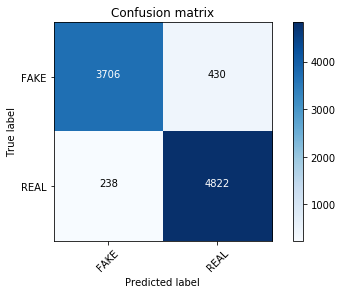

In [221]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [222]:
clf = RandomForestClassifier()
clf.fit(X, y_train)
pickle.dump(clf, open('bi_pos_sem_rf', 'wb'))
pred = clf.predict(Y)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

Accuracy with RandomForestClassifier:   0.868


Confusion matrix


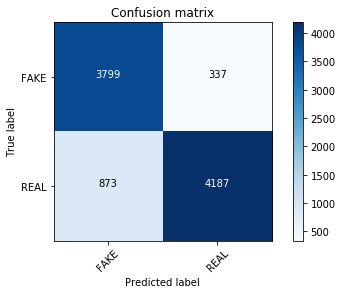

In [223]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [214]:
clf = GradientBoostingClassifier()
clf.fit(X, y_train)
pickle.dump(clf, open('pos_gb', 'wb'))
pred = clf.predict(Y)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

Accuracy with Gradient Boosting:   0.915


Confusion matrix


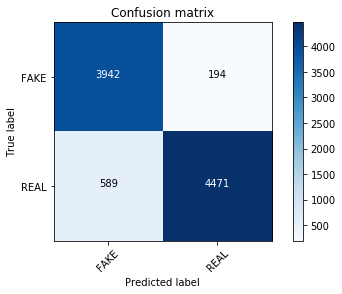

In [215]:
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
#For testing any new article 
a = (open('a.txt'))
x_test = a.read()

In [ ]:
#Tf-idf Bigrams
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2), max_features = 20000) 

# Fit and transform the training data 
tfidf1_train = tfidf_vectorizer.fit_transform(x_train_text.astype('str')) 

# Transform the test set 
tfidf1_test = tfidf_vectorizer.transform([x_test])


In [ ]:
nlp = spacy.load('en_core_web_sm')
x = []
text_new = []
doc = nlp(x_test)
for token in doc:
    text_new.append(token.pos_)
txt = ' '.join(text_new)
txt

In [ ]:
#Tf-idf Bigrams
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2)) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(x_train_text_pos.astype('str')) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform([x_test])

In [ ]:
categories = []
a = lexicon.analyze("")
for key, value in a.items():
    categories.append(key)
categories
lexicon = Empath()
semantic = []
cnt = 0
d = lexicon.analyze(x_test)
d
sem = []
for key,value in d.items() :
    sem.append(value)
a = []
for j in range(len(sem)):
    for k in range(int(sem[j])):
        a.append(categories[j])
    b = " ".join(a)
b

In [ ]:
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1)) 

# Fit and transform the training data 
tfidf2_train = tfidf_vectorizer.fit_transform(x_train_semantics.astype('str')) 

# Transform the test set 
tfidf2_test = tfidf_vectorizer.transform([b])

In [ ]:
import scipy.sparse as sp
# ui = sp.vstack(tfidf_train, tfidf1_train)
# yu = tfidf_train.data.tolist()
# yu.append(tfidf1_train.tolist())
# test = tfidf_test.data.tolist() + x_test.tolist()
#print(type(tfidf_train), tfidf_train.shape)
#print(type(tfidf1_train), tfidf1_train.shape)
# print(type(x_train), x_train.shape)
diff_n_rows = tfidf_train.shape[0] - tfidf1_train.shape[0]

Xb_new = sp.vstack((tfidf1_train, sp.csr_matrix((diff_n_rows, tfidf1_train.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

c = sp.hstack((tfidf_train, Xb_new))

diff_n_rows = c.shape[0] - tfidf2_train.shape[0]

Xb_new = sp.vstack((tfidf2_train, sp.csr_matrix((diff_n_rows, tfidf2_train.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

X = sp.hstack((c, Xb_new))
X

dif_n_rows = tfidf_test.shape[0] - tfidf1_test.shape[0]

Xb_ne = sp.vstack((tfidf1_test, sp.csr_matrix((dif_n_rows, tfidf1_test.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

d = sp.hstack((tfidf_test, Xb_ne))

dif_n_rows = d.shape[0] - tfidf2_test.shape[0]

Xb_ne = sp.vstack((tfidf2_test, sp.csr_matrix((dif_n_rows, tfidf2_test.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

Y = sp.hstack((d, Xb_ne))


In [ ]:
clf = MultinomialNB()
#type(x_train.tolist())
clf.fit(X, y_train)
clf.predict(Y)